In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("data.csv",sep=";",index_col="Datetime" ,parse_dates=True)


target = [f"{i}_+{1}" for i in df.columns if "_m_" in i][:-3]

for i,target_sensor in enumerate([i for i in df.columns if "_m_" in i][:-3]):
    df[target[i]] = df[target_sensor].shift(-1) #we add a shifted version of target to df

df = df.iloc[:-1]#we remove useless rows
df = df.drop(columns=[i for i in df.columns if "set" in i])



#df = df.drop(columns=['T_m_water'])
df = df.drop(columns=['T_m_ground_post']) # egale tj 15 pas interet

features = list(df.columns.difference(target)) #inlcu pas les t-1 et t-2

print(df.shape)
print(target)
print(features)

(34340, 25)
['T_m_Bathroom_+1', 'T_m_Room1_+1', 'T_m_Room3_+1', 'T_m_Room2_+1', 'T_m_Kitchen_+1', 'T_m_Dining_+1', 'T_m_Living_+1']
['Irradiation', 'Occupancy', 'T_m_Bathroom', 'T_m_Dining', 'T_m_Kitchen', 'T_m_Living', 'T_m_Room1', 'T_m_Room2', 'T_m_Room3', 'T_m_ext', 'T_m_water', 'switch_Bathroom', 'switch_SAM', 'switch_SDS', 'switch_chB', 'switch_chHugo', 'switch_chTim', 'switch_cuisine']


In [52]:
percentage = 0.75
n_samples = df.shape[0]
limit = round(percentage*n_samples)
df_train = df.iloc[:limit,:].copy()
df_train = df_train.iloc[:-1]
df_test = df.iloc[limit: ,:].copy()
df_test = df_test.iloc[:-1]

print("Test set fraction:", len(df_test) / len(df))

Test set fraction: 0.12635410599883518


In [53]:
means = {}
stdevs = {}

for i in target:
    means[i]= df_train[i].mean()
    stdevs[i] = df_train[i].std()

for c in df_train.columns:
     
    mean = df_train[c].mean()
    stdev = df_train[c].std()
    print(c,mean,stdev) 
    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

print(means)
print(stdevs)


T_m_Bathroom 19.75887918486172 3.162264444411822
T_m_Room1 19.7253414002689 3.3463209590465985
T_m_Room3 19.36429603208996 3.270269996306578
T_m_Room2 19.153538451281708 3.650650996024455
T_m_Kitchen 20.52259464204362 2.5193689298240067
T_m_Dining 20.228431503272333 2.5319018284875705
T_m_Living 19.307418580619355 3.0507861978753397
T_m_ext 11.350183895018722 7.824087920504499
T_m_water 32.86112870429014 10.957890783849074
Irradiation 485.1400871482041 838.8902700409617
Occupancy 0.6247874929164305 0.4841858077246842
switch_Bathroom 0.17417247241574718 0.379264046721278
switch_chHugo 0.06513550451681722 0.24676892119113314
switch_chB 0.04853495116503884 0.21489729894392887
switch_chTim 0.1886062868762292 0.39120206658316165
switch_cuisine 0.06886896229874329 0.2532353964346751
switch_SAM 0.10250341678055935 0.3033142480698824
switch_SDS 0.22067402246741558 0.41470800718610673
T_m_Bathroom_+1 19.758645843750347 3.1623130552483394
T_m_Room1_+1 19.725132504416813 3.3462767539907596
T_m_Ro

In [54]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]


In [55]:
sequence_length = 25 

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

df_train.head()

from torch.utils.data import DataLoader
torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(y.shape)


torch.Size([3, 25, 18])
torch.Size([3, 7])


In [56]:
torch.manual_seed(101)

batch_size = 3
sequence_length = 4

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

print(test_loader)

Features shape: torch.Size([3, 4, 18])
Target shape: torch.Size([3, 7])


Epoch: 3400, loss: 0.00368

In [57]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [58]:
learning_rate = 5e-5
num_hidden_units = len(features)

#model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
print(len(features))
model = LSTMModel(len(features),num_hidden_units,4,len(target))
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

18


In [59]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)# casse
            total_loss += loss_function(output,y).item()
            
            
    
    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(5):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 0.4457018895000065

Epoch 0
---------
Train loss: 0.2978295919859782
Test loss: 0.15703476519654064

Epoch 1
---------
Train loss: 0.13499497050847858
Test loss: 0.14770539188416418

Epoch 2
---------
Train loss: 0.09178649945007637
Test loss: 0.08617753188419282

Epoch 3
---------
Train loss: 0.07214554902464151
Test loss: 0.07630463250469913

Epoch 4
---------
Train loss: 0.06265374659982044
Test loss: 0.06964908265534456



In [60]:
def predict(data_loader, model,forecast=False):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        flag = False
        for X, _ in data_loader:
            if flag and forecast:
                X[:,-1,2:9] = y_star
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
            flag = True
            

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
ypredict = [f'{i}_predict' for i in target]
yforecast = [f'{i}_forecast' for i in target]

train_for = predict(train_eval_loader, model,True).numpy()
test_for = predict(test_loader, model,True).numpy()

train = predict(train_eval_loader, model).numpy()
test = predict(test_loader, model).numpy()


for i,j in enumerate(ypredict):
    df_train[j] = train[:,i]
    df_test[j] = test[:,i]

for i,j in enumerate(yforecast):
    df_train[j] = train_for[:,i]
    df_test[j] = test_for[:,i]
    

df_out = pd.concat((df_train, df_test))[target+ypredict+yforecast]

for c in df_out.columns:
    c_f = c.replace('_predict','').replace('_forecast','')
    df_out[c] = df_out[c] * stdevs[c_f] + means[c_f]
    

print(df_out)

                           T_m_Bathroom_+1  T_m_Room1_+1  T_m_Room3_+1  \
Datetime                                                                 
2020-06-01 00:00:00+00:00        22.600000     23.500000         19.30   
2020-06-01 00:15:00+00:00        22.600000     23.500000         19.15   
2020-06-01 00:30:00+00:00        22.500000     23.466667         19.00   
2020-06-01 00:45:00+00:00        22.500000     23.400000         19.00   
2020-06-01 01:00:00+00:00        22.500000     23.400000         18.80   
...                                    ...           ...           ...   
2021-05-24 15:30:00+00:00        19.300000     20.300000         19.00   
2021-05-24 15:45:00+00:00        19.300000     20.300000         19.00   
2021-05-24 16:00:00+00:00        19.300000     20.300000         19.00   
2021-05-24 16:15:00+00:00        19.366667     20.300000         19.00   
2021-05-24 16:30:00+00:00        19.466667     20.300000         19.00   

                           T_m_Room2_

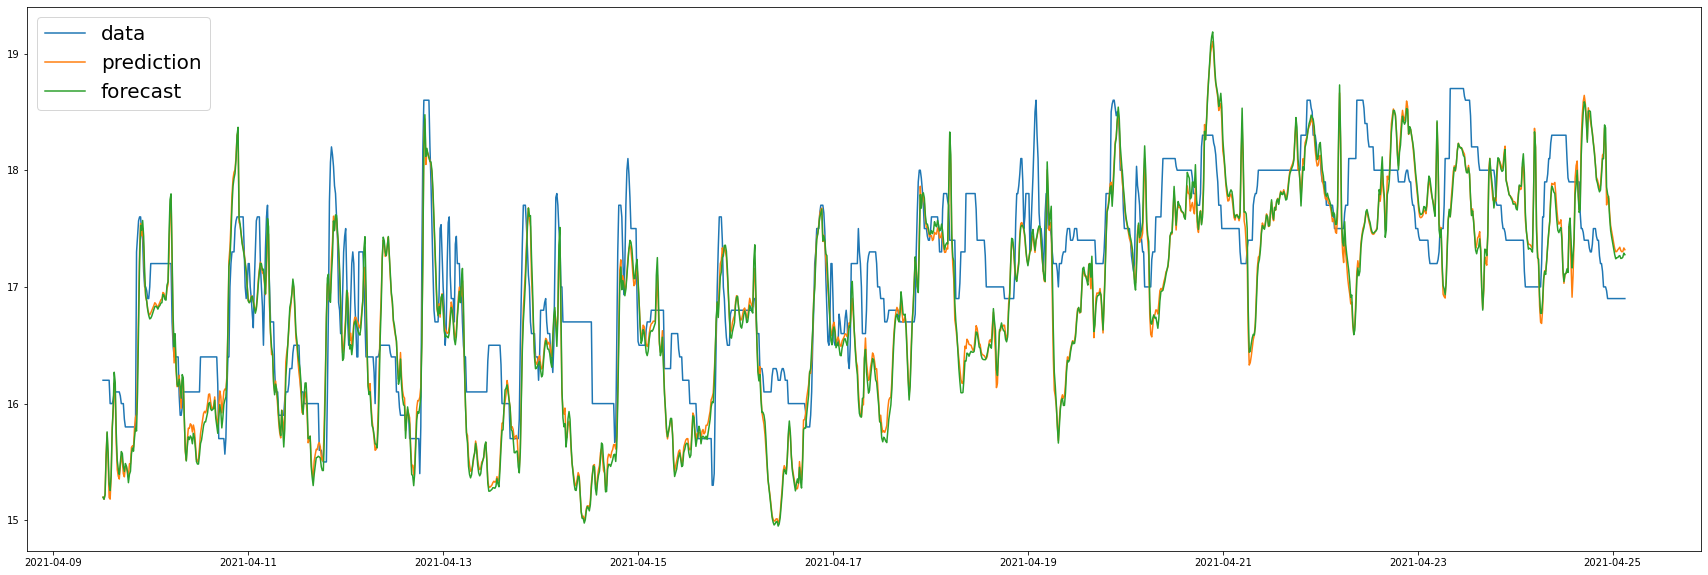

In [74]:

time = [i *15 /60 for i in range(df.shape[0])]
plt.figure(None, figsize=(30, 10))
room = "T_m_Room2"
foc = [f"{room}_+1",f"{room}_+1_predict",f"{room}_+1_forecast"]
plt.plot(df_out[foc][30000:31500])

plt.legend(['data', 'prediction','forecast'], fontsize = 20)


